In [ ]:
# Install necessary packages
%pip install pdfminer.six pandas spacy tensorflow torch torchvision torchaudio joblib fuzzywuzzy python-Levenshtein
!python -m spacy download en_core_web_sm

In [2]:
# Import libraries
import os
import re
import spacy
import numpy as np
import joblib
import matplotlib.pyplot as plt
from pdfminer.high_level import extract_text
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model

In [ ]:
import warnings
import logging
logging.getLogger("pdfminer").setLevel(logging.ERROR)


warnings.filterwarnings("ignore", category=UserWarning, module="pdfminer.pdffont")

def extract_texts_from_folder(folder_path):
    texts = {}
    for filename in os.listdir(folder_path):
        if filename.endswith(".pdf"):
            pdf_path = os.path.join(folder_path, filename)
            try:
                text = extract_text(pdf_path)
                texts[filename] = text
            except Exception as e:
                print(f"Failed to extract {filename}: {e}")
    return texts

# Load resumes
folder_path = "resumes"
all_texts = extract_texts_from_folder(folder_path)

for filename, text in all_texts.items():
    print(f"\n--- {filename} ---")
    print(text[:900])


In [4]:
def clean_text(text):
    text = re.sub(r'\n+', '\n', text)
    text = re.sub(r' +', ' ', text)
    return text.strip()

# Clean all texts
cleaned_texts = {filename: clean_text(text) for filename, text in all_texts.items()}

In [5]:
nlp = spacy.load("en_core_web_sm")

In [ ]:
import re
import spacy
from fuzzywuzzy import fuzz

nlp = spacy.load("en_core_web_sm")

# Define section keywords
EDU_KEYWORDS = ["education", "academic background", "academic qualifications", "qualifications"]
EXP_KEYWORDS = ["experience", "work experience", "professional experience", "employment history", "career history"]
PROJ_KEYWORDS = ["projects", "personal projects", "project experience", "relevant projects"]

# Expanded skill set
SKILL_SET = ['tensorflow', 'keras', 'pytorch', 'machine learning', 'deep learning', 'flask', 'streamlit', 'react', 'django', 'node js', 'react js', 'php', 'laravel', 'magento', 'wordpress', 'javascript', 'angular js', 'c#', 'android', 'android development', 'flutter', 'kotlin', 'xml', 'kivy', 'ios', 'ios development', 'swift', 'cocoa', 'cocoa touch', 'xcode', 'ux', 'adobe xd', 'figma', 'zeplin', 'balsamiq', 'ui', 'prototyping', 'wireframes', 'storyframes', 'adobe photoshop', 'photoshop', 'editing', 'adobe illustrator', 'illustrator', 'adobe after effects', 'after effects', 'adobe premier pro', 'premier pro', 'adobe indesign', 'indesign', 'wireframe', 'solid', 'grasp', 'user research', 'user experience', 'aws', 'google cloud platform', 'microsoft azure', 'docker', 'kubernetes', 'jenkins', 'github actions', 'terraform', 'ci/cd', 'ansible', 'apache spark', 'apache kafka', 'hadoop', 'airflow', 'snowflake', 'etl', 'dbt', 'pandas', 'numpy', 'mysql', 'postgresql', 'mongodb', 'sqlite', 'redis', 'firebase', 'cassandra', 'elasticsearch', 'next.js', 'vue.js', 'svelte', 'tailwind css', 'bootstrap', 'rest api', 'graphql', 'websockets', 'typescript', 'go', 'rust', 'scala', 'ruby', 'bash', 'matlab', 'opencv', 'transformers', 'hugging face', 'nltk', 'spacy', 'scikit-learn', 'langchain', 'llm', 'generative ai', 'chatgpt', 'prompt engineering', 'owasp', 'penetration testing', 'burp suite', 'wireshark', 'ethical hacking', 'kali linux', 'selenium', 'junit', 'cypress', 'postman', 'testng', 'appium', 'jira', 'trello', 'asana', 'notion', 'confluence', 'slack', 'agile', 'scrum', 'blender', 'canva', 'sketch', 'invision', 'reactjs', 'node.js', 'angular', 'vue', 'machine-learning', 'deep-learning', 'gcp', 'azure', 'ui/ux', 'adobe premiere', 'adobe aftereffects']

def extract_email(text):
    email_pattern = r'[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}'
    matches = re.findall(email_pattern, text)
    return matches[0] if matches else None

def extract_phone(text):
    phone_pattern = r'(\+?\d{1,3}[\s.-]?)?\(?\d{3}\)?[\s.-]?\d{3}[\s.-]?\d{4}'
    matches = re.findall(phone_pattern, text)
    return normalize_phone(matches[0]) if matches else "N/A"

def normalize_phone(phone):
    if not phone:
        return "N/A"
    return re.sub(r'[^\d+]', '', phone)

def extract_name(text):
    doc = nlp(text)
    for ent in doc.ents:
        if ent.label_ == "PERSON":
            return ent.text
    lines = text.splitlines()[:5]
    name_pattern = r'^[A-Z][a-zA-Z\s]*(?:[A-Z][a-zA-Z\s]*){1,3}$'
    for line in lines:
        line = line.strip()
        if re.match(name_pattern, line):
            return line
    return "N/A"

def extract_skills_from_text(text, skill_set, threshold=90):
    text = text.lower()
    found_skills = set()
    doc = nlp(text)
    tokens = [token.text.lower() for token in doc]
    
    for skill in skill_set:
        skill_lower = skill.lower()
        if re.search(r'\b' + re.escape(skill_lower) + r'\b', text):
            found_skills.add(skill)
        else:
            for token in tokens:
                if fuzz.ratio(skill_lower, token) > threshold:
                    found_skills.add(skill)
                    break
    return sorted(list(found_skills))

def extract_section(text, section_names, max_section_length=2000):
    lower_text = text.lower()
    headers_positions = []
    
    for sec in section_names:
        pattern = r'(?m)^\s*' + re.escape(sec.lower()) + r'\s*[:\-\s]?\s*$'
        for match in re.finditer(pattern, lower_text):
            headers_positions.append((match.start(), sec))
    
    if not headers_positions:
        return None
    
    headers_positions.sort(key=lambda x: x[0])
    start_pos, matched_section = headers_positions[0]
    
    next_headers = [pos for pos, _ in headers_positions if pos > start_pos]
    end_pos = min(next_headers) if next_headers else min(start_pos + max_section_length, len(text))
    
    section_text = text[start_pos:end_pos].strip()
    section_text_lines = section_text.splitlines()
    if section_text_lines and any(sec.lower() in section_text_lines[0].lower() for sec in section_names):
        section_text_lines = section_text_lines[1:]
    
    return "\n".join(section_text_lines).strip()

def process_resume(text, idx, skill_set):
    try:
        name = extract_name(text)
        email = extract_email(text)
        phone = extract_phone(text)
        skills = extract_skills_from_text(text, skill_set)
        education = extract_section(text, EDU_KEYWORDS)
        experience = extract_section(text, EXP_KEYWORDS)
        projects = extract_section(text, PROJ_KEYWORDS)
        
        print(f"PDF {idx + 1}: Name: {name}, Email: {email}, Phone: {phone}, Skills: {', '.join(skills) if skills else 'N/A'}")
        print(f"Education:\n{education if education else 'N/A'}\n")
        print(f"Experience:\n{experience if experience else 'N/A'}\n")
        print(f"Projects:\n{projects if projects else 'N/A'}\n")
        print("-" * 80)
    except Exception as e:
        print(f"Error processing PDF {idx + 1}: {str(e)}")

# Process resumes (assuming `texts` is a list of resume texts)
for idx, text in enumerate(texts):
    process_resume(text, idx, SKILL_SET)

In [6]:
texts = list(cleaned_texts.values())
labels = [1] * len(texts)  # Dummy binary labels

# Tokenize
vocab_size = 1000
max_length = 100
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(texts)

sequences = tokenizer.texts_to_sequences(texts)
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')

# Save tokenizer
joblib.dump(tokenizer, 'tokenizer.pkl')


['tokenizer.pkl']

In [8]:
model = Sequential([
    Embedding(input_dim=5000, output_dim=16),
    GlobalAveragePooling1D(),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')  # Binary classification
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Dummy data split
X_train = padded_sequences
y_train = np.array(labels)


# Train model
history = model.fit(X_train, y_train, epochs=10, validation_split=0.2, verbose=1)

# Save training history
train_losses = history.history['loss']
val_losses = history.history['val_loss']
train_accuracies = history.history['accuracy']
val_accuracies = history.history['val_accuracy']

Epoch 1/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 448ms/step - accuracy: 0.5938 - loss: 0.6920 - val_accuracy: 1.0000 - val_loss: 0.6798
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 1.0000 - loss: 0.6786 - val_accuracy: 1.0000 - val_loss: 0.6668
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 0.6653 - val_accuracy: 1.0000 - val_loss: 0.6530
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 1.0000 - loss: 0.6512 - val_accuracy: 1.0000 - val_loss: 0.6386
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 1.0000 - loss: 0.6364 - val_accuracy: 1.0000 - val_loss: 0.6237
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 1.0000 - loss: 0.6212 - val_accuracy: 1.0000 - val_loss: 0.6083
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 1.0000 - loss: 0.6060 - val_accuracy: 1.0000 - val_loss: 0.5924
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 0.5895 - val_accuracy: 1.0000 - val_loss:

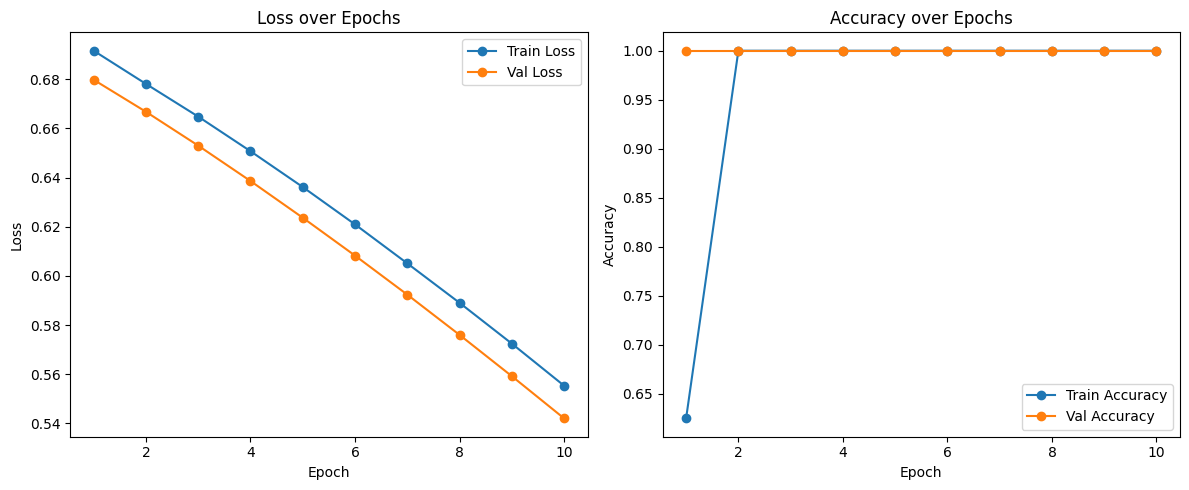

In [9]:
epochs = range(1, len(train_losses) + 1)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss', marker='o')
plt.plot(epochs, val_losses, label='Val Loss', marker='o')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy', marker='o')
plt.plot(epochs, val_accuracies, label='Val Accuracy', marker='o')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.savefig('training_metrics.png')

In [10]:
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)


model.save('resume_parser_model.h5')
model.save_weights('resume_parser.weights.h5')
print("Model and weights saved.")

Model and weights saved.


In [11]:
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)


from tensorflow.keras.models import load_model
import joblib
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Load model and tokenizer
model = load_model("resume_parser_model.h5")
tokenizer = joblib.load("tokenizer.pkl")

# Function to preprocess and predict
def parse_and_classify_resume(pdf_path):
    # Load and extract text
    text = extract_text(pdf_path)

    # Extract fields
    email = extract_email(text)
    phone = extract_phone(text)
    name = extract_name(text)
    skills = extract_skills_from_text(text, SKILL_SET)
    education = extract_section(text, EDU_KEYWORDS) 
    experience = extract_section(text, EXP_KEYWORDS)
    projects = extract_section(text, PROJ_KEYWORDS)

    # Load tokenizer and model
    tokenizer = joblib.load("tokenizer.pkl")
    model = load_model("resume_parser_model.h5")

    # Preprocess text for prediction
    sequence = tokenizer.texts_to_sequences([text])
    new_data = pad_sequences(sequence, maxlen=100, padding='post', truncating='post')

    # Predict
    prediction = model.predict(new_data)[0][0]
    label = "Relevant" if prediction > 0.5 else "Not Relevant"

    # Combine results
    return {
        "Name": name,
        "Email": email,
        "Phone": phone,
        "Skills": skills,
        
        "Prediction": label,
        "Confidence": round(float(prediction), 2)
    }

In [ ]:
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)

result = parse_and_classify_resume("90280583.pdf")
print(result)
